# Classification Exercises - From Hands On Machine Learning

## The Titanic Dataset

In [88]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [89]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [90]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

The data is already split into training and test sets. The test set does not contain the labels! 

In [91]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [92]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Attribute Description**

1. Survived: The target variable, 0 for "did not survive" and 1 for "survived"
2. Pclass : Passenger class
3. Name, Sex, Age: Demographics
4. SibSp: How many siblings and spouses of the passengers were aboard the Titanic.
5. Parch: How many parents and children of the passengers were aboard the Titanic.
6. Ticket id and Fare: self explanatory
7. Cabin: passenger's cabin number
8. Embarked: Port of embarkation for the passenger

In [93]:
# Taking a look at training data details
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The Age, Cabin and Embarked attributes are sometimes null (less than 891 non-null), especially the Cabin (77% are null). We will ignore the Cabin for now and focus on the rest. The Age attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The Name and Ticket attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:


In [94]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Only 38% survived. Since there are nearly 40%, accuracy will be a reasonable metric to evaluate our model.**

**The mean Fare was 32.20.**

**The mean Age was less than 30 years old.**

In [95]:
# Taking a deeper look at the target variable
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [96]:
# Taking a look at categorical attributes
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [97]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [98]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Here ports of embarkation are S=Southampton, Q=Queestown, C=Cherbourg**

**NOTE:**

We will use a mix of Pipeline, FeatureUnion and a customer DataFrame selector to preprocess some columns differently (using a ColumnTransformer is the preferred method)

In [99]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

In [100]:
# Building pipeline for numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median"))
])

In [101]:
# Now, using our pipeline to impute median values on all numerical columns
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also need an imputer to string categorical columns.

In [102]:
# Inspired from stackoverflow.com/questions/25239958
# Go over this numerous times.

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [103]:
# Creating our pipeline for categorical variables
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False))
])

In [104]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [105]:
# Joining the numerical and categorical pipelines:

from sklearn.pipeline import FeatureUnion

preprocessing_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
])

**Our pre-processing pipeline takes the raw data and outputs numerical input features so that we can feed it to any ML model we want**

In [106]:
X_train = preprocessing_pipeline.fit_transform(train_data)

In [107]:
# Defining our labels
y_train = train_data["Survived"]

In [108]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [109]:
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Let us begin to train our classifier. Beginning with SVC.

In [110]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [111]:
# Now that our model is trained, let's make a prediction on the test set
X_test = preprocessing_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

Using cross-validation to get an idea of how good this first model is:

In [112]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=15)
svm_scores.mean()

0.735552308591467

This is definitely NOT the score we are looking for!

Let's try to push the score well over the 80% mark to be near the top 10% of the Kaggle competition.

In [113]:
# Training a RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=150, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=15)
forest_scores.mean()

0.8138242743035261

Instead of simply looking at the means, let's plot all 10 scores for each model, along with a box and whiskers plot showing the quartiles as well. This plot will also include outliers.

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

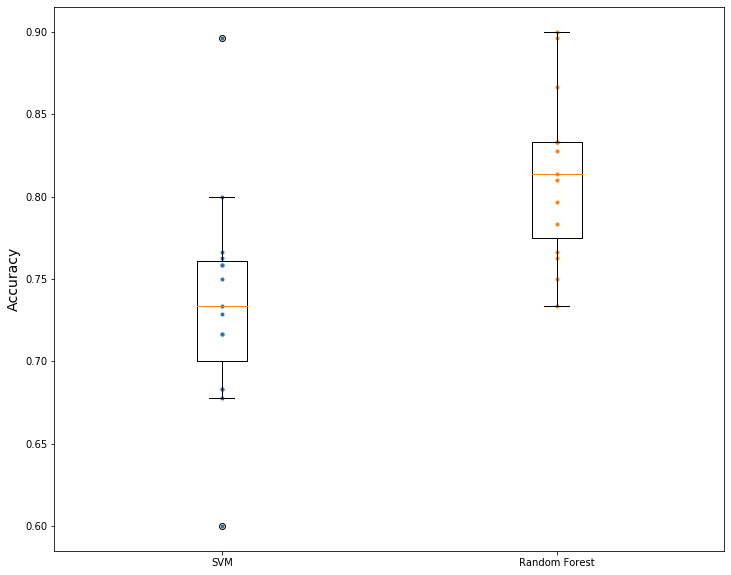

In [115]:
plt.figure(figsize=(12, 10))
plt.plot([1]*15, svm_scores, ".")
plt.plot([2]*15, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()



To improve this result further, we could:

- Compare many more models and tune hyperparameters using cross validation and grid search,
- Do more feature engineering, for example:
    - replace SibSp and Parch with their sum,
    - try to identify parts of names that correlate well with the Survived attribute (e.g. if the name contains "Countess", then survival seems more likely),
- try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).



In [116]:
# As an example of the aforementioned
# Adding additional features such as age bucket
train_data["AgeBucket"] = train_data["Age"] // 15*15

In [117]:
train_data[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [118]:
train_data["RelativesOnBoard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnBoard", "Survived"]].groupby(["RelativesOnBoard"]).mean()

,Survived
RelativesOnBoard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [119]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnBoard
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,15.0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,15.0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,15.0,0


In [120]:
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [121]:
import numpy as np

# Taking the sum of SibSp and Parch
train_data["TravelingAlone"] = np.where(train_data['RelativesOnBoard']>0, 0, 1)

In [122]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnBoard,TravelingAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,15.0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,30.0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,15.0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,30.0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,30.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,211536,13.0000,NaN,S,15.0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,112053,30.0000,B42,S,15.0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,W./C. 6607,23.4500,NaN,S,NaN,3,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,111369,30.0000,C148,C,15.0,0,1


In [127]:
# Rerunning our piplelines
num_pipeline2 = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "Fare", "RelativesOnBoard"])),
        ("imputer", SimpleImputer(strategy='median'))
])

In [128]:
num_pipeline2.fit_transform(train_data)

array([[22.    ,  7.25  ,  1.    ],
       [38.    , 71.2833,  1.    ],
       [26.    ,  7.925 ,  0.    ],
       ...,
       [28.    , 23.45  ,  3.    ],
       [26.    , 30.    ,  0.    ],
       [32.    ,  7.75  ,  0.    ]])

In [129]:
cat_pipeline2 = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked", "AgeBucket", "TravelingAlone"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False))
])

In [131]:
cat_pipeline2.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [132]:
# Joining the reprocessed columns from the second pass
preprocessing_pipeline2 = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline2),
            ("cat_pipeline", cat_pipeline2)
])

In [133]:
# Creating our second pass - preprocessed training set
X_train = preprocessing_pipeline2.fit_transform(train_data)

In [134]:
X_train

array([[22.    ,  7.25  ,  1.    , ...,  0.    ,  1.    ,  0.    ],
       [38.    , 71.2833,  1.    , ...,  0.    ,  1.    ,  0.    ],
       [26.    ,  7.925 ,  0.    , ...,  0.    ,  0.    ,  1.    ],
       ...,
       [28.    , 23.45  ,  3.    , ...,  0.    ,  1.    ,  0.    ],
       [26.    , 30.    ,  0.    , ...,  0.    ,  0.    ,  1.    ],
       [32.    ,  7.75  ,  0.    , ...,  0.    ,  0.    ,  1.    ]])

In [135]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

**Re - running our classifiers from before**

In [136]:
# Re-training the Support Vector Machine
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [145]:
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=15)
svm_scores.mean()

0.7277355672446262

In [148]:
# Retraining our random forest classifier
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [152]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=20)
forest_scores.mean()

0.8071201141853315

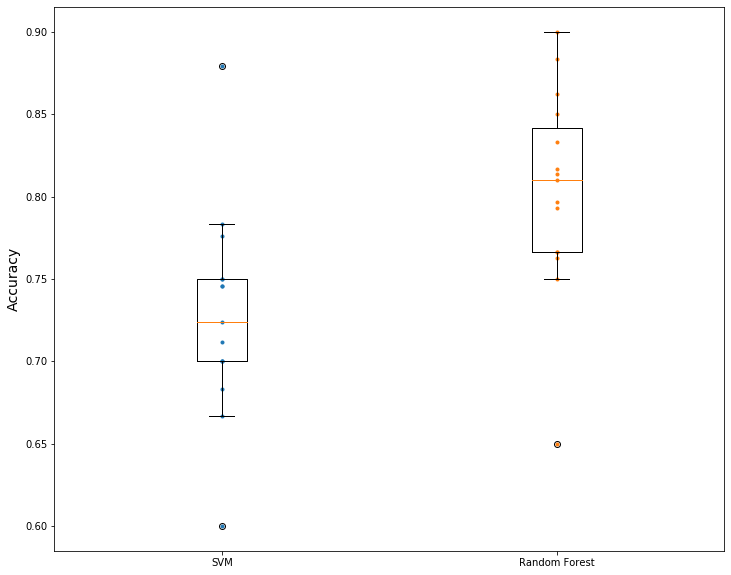

In [150]:
plt.figure(figsize=(12, 10))
plt.plot([1]*15, svm_scores, ".")
plt.plot([2]*15, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [ ]:
# Clearly there is more featur engineering which could help us improve our score.